# Generate plots for optimal combination workflow

In [1]:
%matplotlib inline
import os.path as op
from glob import glob

import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting, masking
from nilearn.image import math_img

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Load data
data_dir = '/Users/tsalo/Documents/me-dsets/logans_dset/sub-ltd/func/'
ted_dir = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/e8-checkerboard-test/'
files = ['sub-ltd_task-checkerboard_echo-1_bold.nii.gz',
         'sub-ltd_task-checkerboard_echo-2_bold.nii.gz',
         'sub-ltd_task-checkerboard_echo-3_bold.nii.gz',
         'sub-ltd_task-checkerboard_echo-4_bold.nii.gz',
         'sub-ltd_task-checkerboard_echo-5_bold.nii.gz',
         'sub-ltd_task-checkerboard_echo-6_bold.nii.gz',
         'sub-ltd_task-checkerboard_echo-7_bold.nii.gz',
         'sub-ltd_task-checkerboard_echo-8_bold.nii.gz']
files = [op.join(data_dir, f) for f in files]
#imgs = [nib.load(f) for f in files]
echo_times = np.array([9.58, 21.95, 34.32, 46.69, 59.06, 71.43, 83.8, 96.17])

adaptive_mask_file = op.join(ted_dir, 'adaptive_mask.nii')
mask = math_img('img >= 3', img=adaptive_mask_file)

# first component is checkerboard
betas_file = op.join(ted_dir, 'betas_OC.nii')
betas = masking.apply_mask(betas_file, mask)
voxel_idx = np.where(betas[0, :] == np.max(betas[0, :]))[0][0]

# load data
data = [masking.apply_mask(f, mask) for f in files]
ts = [d[:, voxel_idx] for d in data]
ts_1d = np.hstack(ts)

n_echoes = len(data)
n_trs = data[0].shape[0]

pal = sns.color_palette('cubehelix', n_echoes)

In [3]:
# Prepare data for model
log_data = np.log(np.abs(ts_1d) + 1)
# log_data = np.log(ts_1d)  # in a perfect world...
x = np.column_stack([np.ones(n_echoes), -1 * echo_times])
X = np.repeat(x, n_trs, axis=0)  # T * E

# Model fit
betas = np.linalg.lstsq(X, log_data, rcond=None)[0]
s0 = np.exp(betas[0])
r2s = betas[1]
t2s = 1. / r2s

# Values for plots
# Values from log-linear model
log_x = np.arange(-1000, 0, .01)
log_y = betas[0] + log_x*betas[1]

# Values from monoexponential decay model
mono_x = np.arange(0, 1000, .01)
mono_y = np.exp(-1*betas[1]*mono_x) * s0

# Get weights for optimal combination
alpha = echo_times * np.exp(-echo_times / t2s)
alpha = alpha / np.sum(alpha)  # unnecessary but good for bar plot below

# Combine data across echoes
oc = np.average(np.vstack(ts), axis=0, weights=alpha)

## Echo-specific timeseries

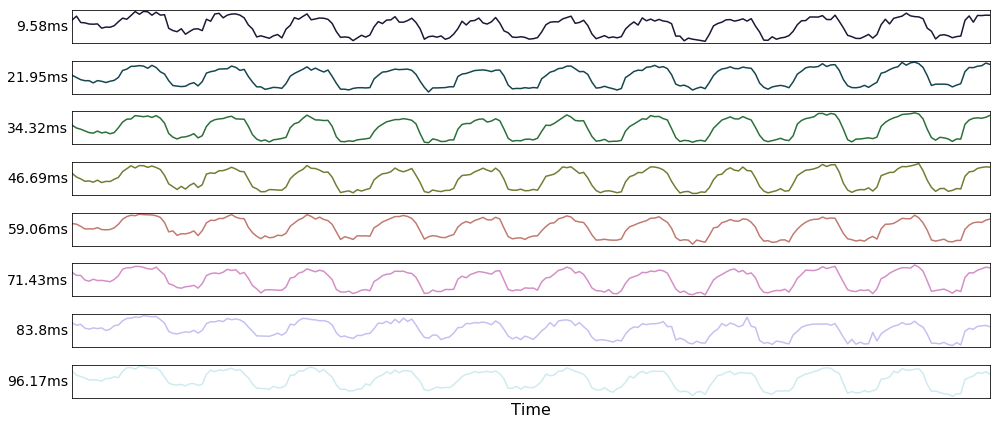

In [4]:
fig, axes = plt.subplots(n_echoes, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel('{0}ms'.format(echo_times[i_echo]), rotation=0, va='center', ha='right', fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].set_xlabel('Time', fontsize=16)
axes[-1].set_xlim(0, len(ts[i_echo])-1)
fig.tight_layout()
fig.savefig('a01_echo_timeseries.png', dpi=400)

## Echo-specific data and echo time

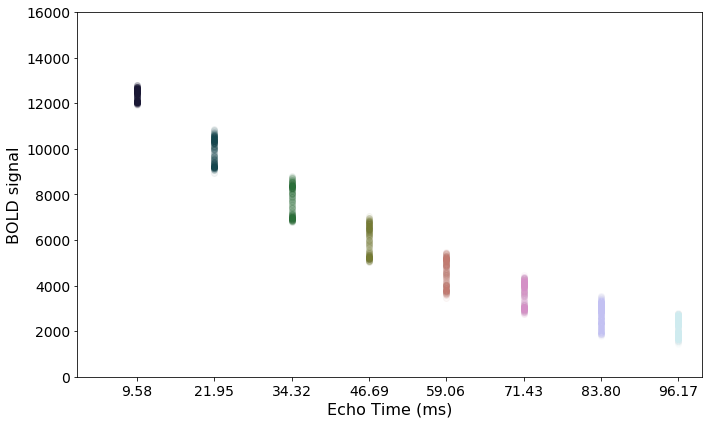

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
values = [i[0] for i in ts]
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echo_times)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
fig.tight_layout()
fig.savefig('a02_echo_value_distributions.png', dpi=400)

## Adaptive mask
Longer echo times are more susceptible to signal dropout, which means that certain brain regions (e.g., orbitofrontal cortex, temporal poles) will only have good signal for some echoes. In order to avoid using bad signal from affected echoes in calculating $T_{2}^*$ and $S_{0}$ for a given voxel, `tedana` generates an adaptive mask, where the value for each voxel is the number of echoes with "good" signal. When $T_{2}^*$ and $S_{0}$ are calculated below, each voxel's values are only calculated from the first $n$ echoes, where $n$ is the value for that voxel in the adaptive mask.

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


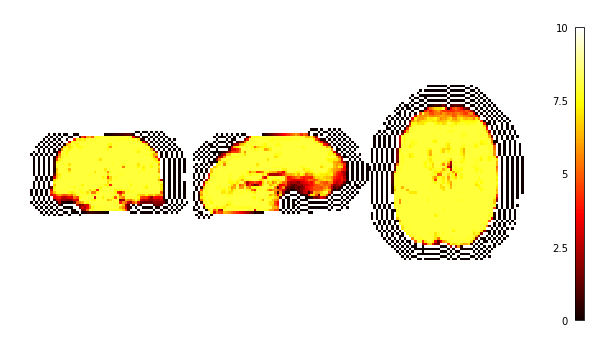

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

plotting.plot_stat_map(adaptive_mask_file, vmax=10, alpha=1,
                       draw_cross=False, colorbar=True,
                       annotate=False, bg_img=None, figure=fig, axes=ax)
fig.savefig('a03_adaptive_mask.png', dpi=400)

## Log-linear transformation

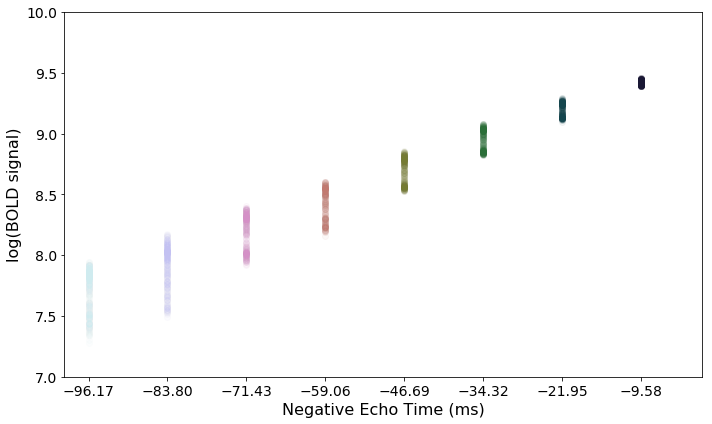

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.set_ylabel('log(BOLD signal)', fontsize=16)
ax.set_xlabel('Negative Echo Time (ms)', fontsize=16)
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-100, 0)
ax.set_ylim(7, 10)
ax.tick_params(axis='both', which='major', labelsize=14)

fig.tight_layout()
fig.savefig('a04_echo_log_value_distributions.png', dpi=400)

## Log-linear model

Let $S$ be the BOLD signal for a given echo.

Let $TE$ be the echo time in milliseconds.

$$\log_{e}(\left|\begin{pmatrix}
S(TE_{1}) \\
S(TE_{2}) \\
\vdots \\
S(TE_{n})\end{pmatrix}\right|
+
\begin{pmatrix}
1 \\
1 \\
\vdots \\
1\end{pmatrix}
) = B_{1}
\begin{pmatrix}
-TE_{1} \\
-TE_{2} \\
\vdots \\
-TE_{n}\end{pmatrix} + 
\begin{pmatrix}
B_{0} \\
B_{0} \\
\vdots \\
B_{0}\end{pmatrix}$$

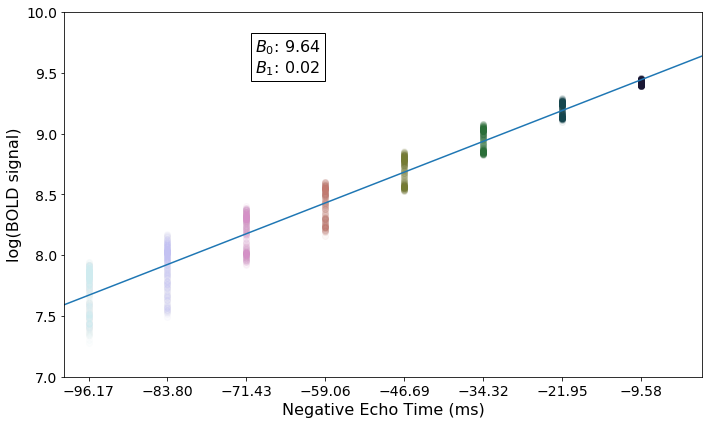

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.plot(log_x, log_y)

ax.set_ylabel('log(BOLD signal)', fontsize=16)
ax.set_xlabel('Negative Echo Time (ms)', fontsize=16)
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-100, 0)
ax.set_ylim(7, 10)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.annotate('$B_0$: {0:.02f}\n$B_1$: {1:.02f}'.format(betas[0], betas[1]),
            xy=(-70, 9.5), fontsize=16,
            bbox=dict(fc="white", ec="black", lw=1))

fig.tight_layout()
fig.savefig('a05_loglinear_regression.png', dpi=400)

# Monoexponential decay model
Calculation of $S_{0}$ and $T_{2}^{*}$
$$S_{0} = e^{B_{0}}$$

$$T_{2}^{*} = \frac{1}{B_{1}}$$

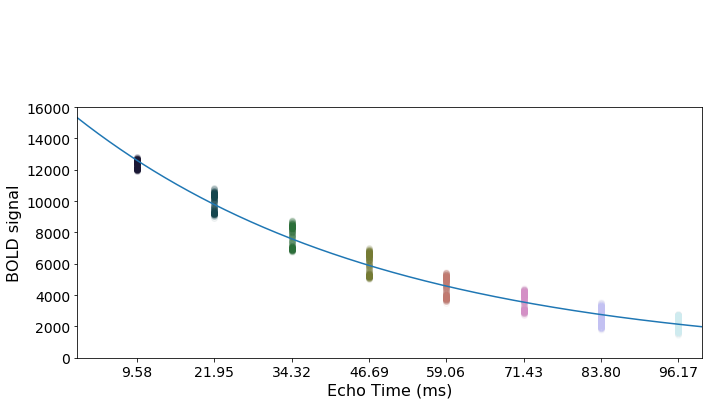

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echo_times)
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.annotate('$S_0$: {0:.02f}\n$T_2^*$: {1:.02f}'.format(s0, t2s),
            xy=(60, 20000), fontsize=16,
            bbox=dict(fc="white", ec="black", lw=1))

fig.tight_layout()
fig.savefig('a06_monoexponential_decay_model.png', dpi=400)

## T2*

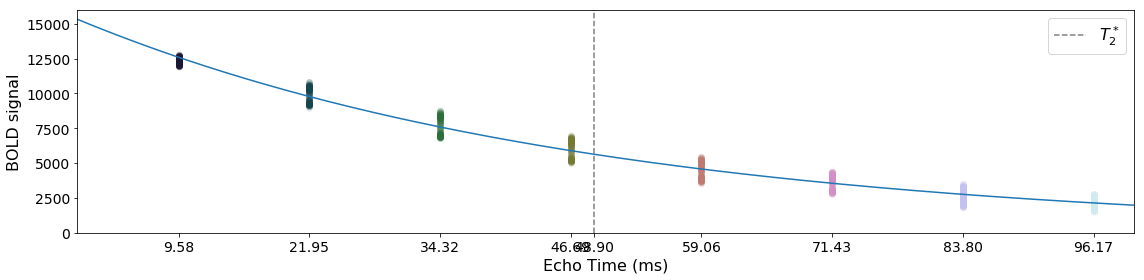

In [10]:
fig, ax = plt.subplots(figsize=(16, 4))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.axvline(t2s, 0, 1, label='$T_2^*$', color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(np.hstack((echo_times, [np.round(t2s, 1)])))
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
ax.tick_params(axis='both', which='major', labelsize=14)

legend = ax.legend(frameon=True, fontsize=16)

fig.tight_layout()
fig.savefig('a07_monoexponential_decay_model_with_t2.png', dpi=400)

## Optimal combination weights

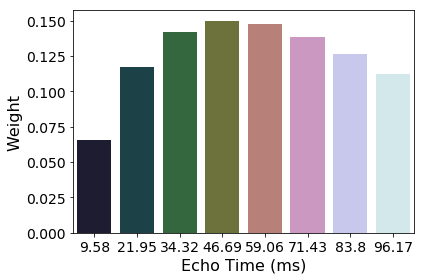

In [11]:
fig, ax = plt.subplots()
sns.barplot(echo_times, alpha, ax=ax, palette=pal)
ax.set_ylabel('Weight', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
fig.savefig('a08_optimal_combination_echo_weights.png', dpi=400)

## Optimally combined timeseries

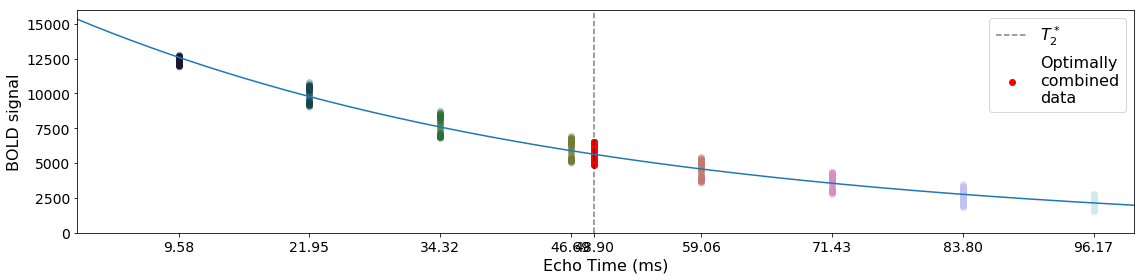

In [12]:
fig, ax = plt.subplots(figsize=(16, 4))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

# Optimal combination
rep_t2s = np.ones(n_trs) * t2s
ax.scatter(rep_t2s, oc, alpha=1, color='red', label='Optimally\ncombined\ndata')

ax.axvline(t2s, 0, 20000, label='$T_2^*$', color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(np.hstack((echo_times, [np.round(t2s, 1)])))
ax.set_xlim(0, 100)
ax.set_ylim(0, 16000)
ax.tick_params(axis='both', which='major', labelsize=14)

legend = ax.legend(frameon=True, fontsize=16)

fig.tight_layout()
fig.savefig('a09_optimal_combination_value_distributions.png', dpi=400)

## Optimally combined timeseries

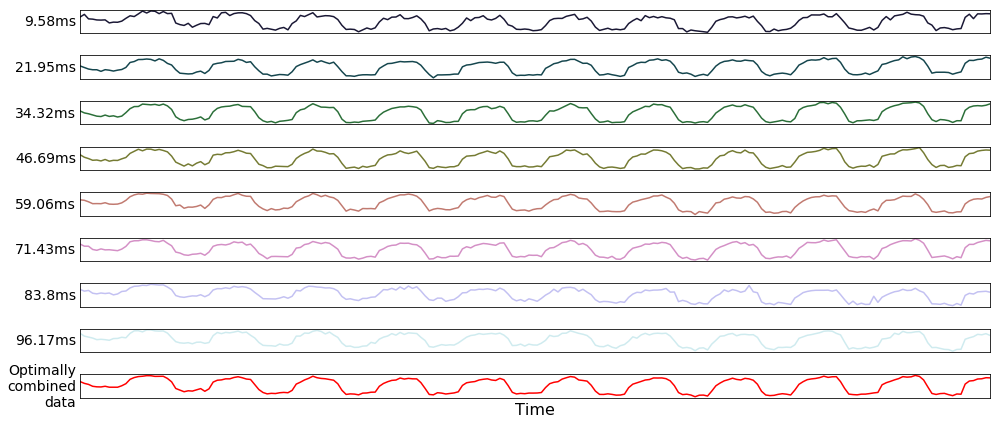

In [13]:
fig, axes = plt.subplots(n_echoes+1, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel('{0}ms'.format(echo_times[i_echo]), rotation=0, va='center', ha='right', fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].plot(oc, color='red')
axes[-1].set_ylabel('Optimally\ncombined\ndata', rotation=0, va='center', ha='right', fontsize=14)
axes[-1].set_xlabel('Time', fontsize=16)
axes[-1].set_yticks([])
axes[-1].set_xticks([])
axes[-1].set_xlim(0, len(ts[i_echo])-1)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
fig.savefig('a10_optimal_combination_timeseries.png', dpi=400)

In [14]:
# Optimally combined data
oc_file = op.join(ted_dir, 'ts_OC.nii')

oc = masking.apply_mask(oc_file, mask)
oc_z = (oc - np.mean(oc, axis=0)) / np.std(oc, axis=0)

# Results from MEPCA
mepca_mmix_file = op.join(ted_dir, 'mepca_mix.1D')
oc_red_file = op.join(ted_dir, 'ts_OC_whitened.nii')

mepca_mmix = np.loadtxt(mepca_mmix_file)
oc_red = masking.apply_mask(oc_red_file, mask)  # PCA-whitened OC data

# Results from MEICA
meica_mmix_file = op.join(ted_dir, 'meica_mix.1D')
weights_file = op.join(ted_dir, 'meica_metric_weights.nii')
meica_betas_file = op.join(ted_dir, 'meica_betas_catd.nii')
r2_pred_file = op.join(ted_dir, 'meica_R2_pred.nii')
s0_pred_file = op.join(ted_dir, 'meica_S0_pred.nii')

meica_mmix = np.loadtxt(meica_mmix_file)
norm_weights = masking.apply_mask(weights_file, mask)
meica_betas = masking.apply_mask(meica_betas_file, mask)
r2_pred_betas = masking.apply_mask(r2_pred_file, mask)
s0_pred_betas = masking.apply_mask(s0_pred_file, mask)

# Multi-echo denoised data
dn_file = op.join(ted_dir, 'dn_ts_OC.nii')
hk_file = op.join(ted_dir, 'hik_ts_OC.nii')
dn_data = masking.apply_mask(dn_file, mask)
hk_data = masking.apply_mask(hk_file, mask)

# Post-processed data
dn_t1c_file = op.join(ted_dir, 'dn_ts_OC_T1c.nii')
hk_t1c_file = op.join(ted_dir, 'hik_ts_OC_T1c.nii')
dn_t1c_data = masking.apply_mask(dn_t1c_file, mask)
hk_t1c_data = masking.apply_mask(hk_t1c_file, mask)

ValueError: File not found: '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/e8-checkerboard-test/dn_ts_OC_T1c.nii'

## Multi-Echo Principal Components Analysis
Optimally combined data are decomposed with PCA.
The PCA components are selected according to one of multiple possible approaches.
Two possible approaches are a decision tree and a threshold using the percentage of variance explained by each component.

In [ ]:
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
i = 0
axes[0].plot(mepca_mmix[:, i])
axes[0].set_title('PCA Component {}'.format(i), fontsize=16)
i = 3
axes[1].plot(mepca_mmix[:, i])
axes[1].set_title('PCA Component {}'.format(i), fontsize=16)
axes[2].plot(mepca_mmix[:, -1])
axes[2].set_title('PCA Component {}'.format(mepca_mmix.shape[0]-1), fontsize=16)
axes[0].set_xlim(0, mepca_mmix.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig('a11_pca_component_timeseries.png', dpi=400)

# Data Whitening
The selected components from the PCA are recombined to produce a whitened version of the optimally combined data.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(oc_red[:, voxel_idx], label='Whitened timeseries', zorder=1.)
ax.plot(oc_z[:, voxel_idx], label='Original timeseries', alpha=0.5, zorder=0., linewidth=3)
legend = ax.legend(frameon=True, fontsize=16)
ax.set_xlim(0, oc_z.shape[0]-1)
ax.set_xticks([])
ax.set_xlabel('Time', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('a12_pca_whitened_data.png', dpi=400)

## Multi-Echo Independent Components Analysis
The whitened optimally combined data are then decomposed with ICA. The number of ICA components is limited to the number of retained components from the PCA, in order to reflect the true dimensionality of the data.
ICA produces a mixing matrix (i.e., timeseries for each component).

In [ ]:
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
i = 89
axes[0].plot(meica_mmix[:, i])
axes[0].set_title('ICA Component {}'.format(i), fontsize=16)
i = 0
axes[1].plot(meica_mmix[:, i])
axes[1].set_title('ICA Component {} (High Kappa)'.format(i), fontsize=16)
i = 68
axes[2].plot(meica_mmix[:, i])
axes[2].set_title('ICA Component {} (High Rho)'.format(i), fontsize=16)
axes[0].set_xlim(0, meica_mmix.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig('a13_ica_component_timeseries.png', dpi=400)

# $R_2$ and $S_0$ Model Fit
Linear regression is used to fit the component timeseries to each voxel in each echo from the original, echo-specific data. This results in echo- and voxel-specific betas for each of the components. TE-dependence ($R_2$) and TE-independence ($S_0$) models can then be fit to these betas.

These models allow calculation of F-statistics for the $R_2$ and $S_0$ models (referred to as $\kappa$ and $\rho$, respectively).

In [ ]:
for i, comp in enumerate([89, 0, 68]):  # only generate plots for a few components
    # Use weight map to average as fitmodels_direct does
    comp_weights = meica_betas[comp, :, voxel_idx]
    r2_pred_weights = r2_pred_betas[comp, :, voxel_idx]
    s0_pred_weights = s0_pred_betas[comp, :, voxel_idx]
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(echo_times, comp_weights, c='black', alpha=0.5, linewidth=5, label='Component PEs')
    ax.plot(echo_times, r2_pred_weights, c='blue', label='Predicted T2* model values')
    ax.plot(echo_times, s0_pred_weights, c='red', label='Predicted S0 model values')
    ax.set_xticks(echo_times)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Echo Time (ms)', fontsize=16)
    temp = np.hstack((comp_weights, s0_pred_weights, r2_pred_weights))
    ax.set_ylim(np.floor(np.min(temp)), np.ceil(np.max(temp)))
    legend = ax.legend(frameon=True, fontsize=14, ncol=3)
    ax.set_title('ICA Component {}'.format(comp), fontsize=16)
    fig.tight_layout()
    fig.savefig('a14_te_dependence_models_component_{}.png'.format(i), dpi=400)

# ICA Component Selection and Multi-Echo Denoising
A decision tree is applied to $\kappa$, $\rho$, and other metrics in order to classify ICA components as TE-dependent (BOLD signal), TE-independent (non-BOLD noise), or neither (to be ignored).

The ICA components are fitted to the original (not whitened) optimally combined data with linear regression, which is used to weight the components for construction of the denoised data. The residuals from this regression will thus include the variance that was not included in the PCA-whitened optimally combined data.

The ME-DN dataset is constructed from the accepted (BOLD) and ignored components, as well as the residual variance not explained by the ICA.
The ME-HK dataset is constructed just from the accepted (BOLD) components. This means that ignored components and residual variance not explained by the ICA are not included in the resulting dataset.

In [ ]:
dn_data_z = (dn_data - np.mean(dn_data, axis=0)) / np.std(dn_data, axis=0)
hk_data_z = (hk_data - np.mean(hk_data, axis=0)) / np.std(hk_data, axis=0)

fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(oc_z[:, voxel_idx], label='Optimally combined')
axes[0].set_title('Optimally combined', fontsize=16)

axes[1].plot(dn_data_z[:, voxel_idx], label='ME-DN')
axes[1].set_title('ME-DN', fontsize=16)

axes[2].plot(hk_data_z[:, voxel_idx])
axes[2].set_title('ME-HK', fontsize=16)
legend = ax.legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()

fig.savefig('a15_denoised_data_timeseries.png', dpi=400)

# Post-processing to remove spatially diffuse noise
Due to the constraints of ICA, MEICA is able to identify and remove spatially localized noise components, but it cannot identify components that are spread out throughout the whole brain.

One of several post-processing strategies may be applied to the ME-DN or ME-HK datasets in order to remove spatially diffuse (ostensibly respiration-related) noise. Methods which have been employed in the past include global signal regression (GSR), T1c-GSR, anatomical CompCor, Go Decomposition (GODEC), and robust PCA.

In [ ]:
dn_t1c_data_z = (dn_t1c_data - np.mean(dn_t1c_data, axis=0)) / np.std(dn_t1c_data, axis=0)
hk_t1c_data_z = (hk_t1c_data - np.mean(hk_t1c_data, axis=0)) / np.std(hk_t1c_data, axis=0)

fig, axes = plt.subplots(2, sharex=True, figsize=(14, 6))
axes[0].plot(dn_t1c_data_z[:, voxel_idx], label='ME-DN T1c')
axes[0].plot(dn_data_z[:, voxel_idx], label='ME-DN', alpha=0.5, linewidth=3, zorder=0.)
axes[0].set_title('ME-DN', fontsize=16)
legend = axes[0].legend(frameon=True, loc='upper right')

axes[1].plot(hk_t1c_data_z[:, voxel_idx], label='ME-HK T1c')
axes[1].plot(hk_data_z[:, voxel_idx], label='ME-HK', alpha=0.5, linewidth=3, zorder=0.)
axes[1].set_title('ME-HK', fontsize=16)
legend = axes[1].legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
axes[1].set_xticks([])
axes[1].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig('a16_t1c_denoised_data_timeseries.png', dpi=400)